In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from PIL import Image
import glob
from astropy.io import fits
import h5py

import tensorflow as tf
from tensorflow import keras, einsum
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
import tensorflow.keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from einops import rearrange
from einops.layers.tensorflow import Rearrange
from functools import partial
from inspect import isfunction
from DataMaker import *

keras.backend.set_image_data_format('channels_first')

2024-03-24 23:53:49.293775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 23:53:49.996573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-03-24 23:53:54.458513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 23:53:54.491457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 23:53:54.491709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
channels = 5
BATCH_SIZE = 32

TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_training.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_testing.hdf5'

gen_args = {
    'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'shuffle': False}

train_gen = HDF5ImageGenerator(TRAIN_PATH, mode = 'train', **gen_args)
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)

In [4]:
timesteps = 1000
learning_rate = 1e-5
min_noise = 0.0001
max_noise = 0.02

# create a fixed beta schedule
beta = np.linspace(min_noise, max_noise, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)

# this function will add noise to the input as per the given timestamp
def forward_noise(x_0, t):
    noise = np.random.normal(size=x_0.shape)
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(num):
    return tf.random.uniform(shape=[num], minval=0, maxval=timesteps, dtype=tf.int32)

(5, 64, 64)


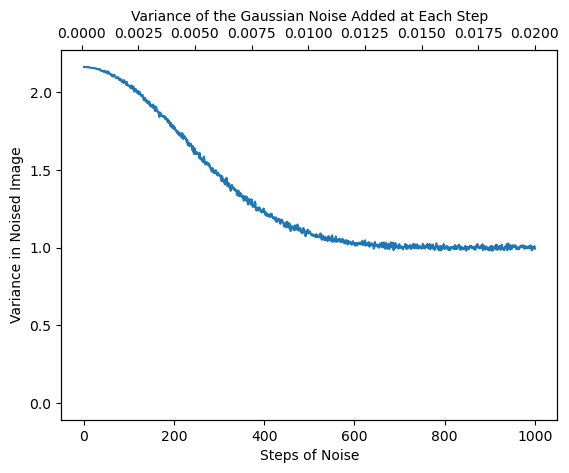

In [5]:
sample = train_gen[0][0][0]
print(sample.shape)
y_arr = np.array([])
for index, i in enumerate(range(timesteps)):
    noisy_im, noise = forward_noise(np.expand_dims(sample, 0), np.array([i, ]))
    y_arr = np.append(y_arr, np.var(noisy_im.flatten()))

x_arr = np.linspace(0, timesteps, timesteps)

fig, ax1 = plt.subplots()
ax1.plot(x_arr, y_arr)
ax1.set_xlabel("Steps of Noise")
ax1.set_ylabel("Variance in Noised Image")

ax2 = ax1.twiny()
ax2.plot(beta, 0 * np.ones(timesteps), alpha = 0) # Create a dummy plot
ax2.set_xlabel("Variance of the Gaussian Noise Added at Each Step")
plt.show()

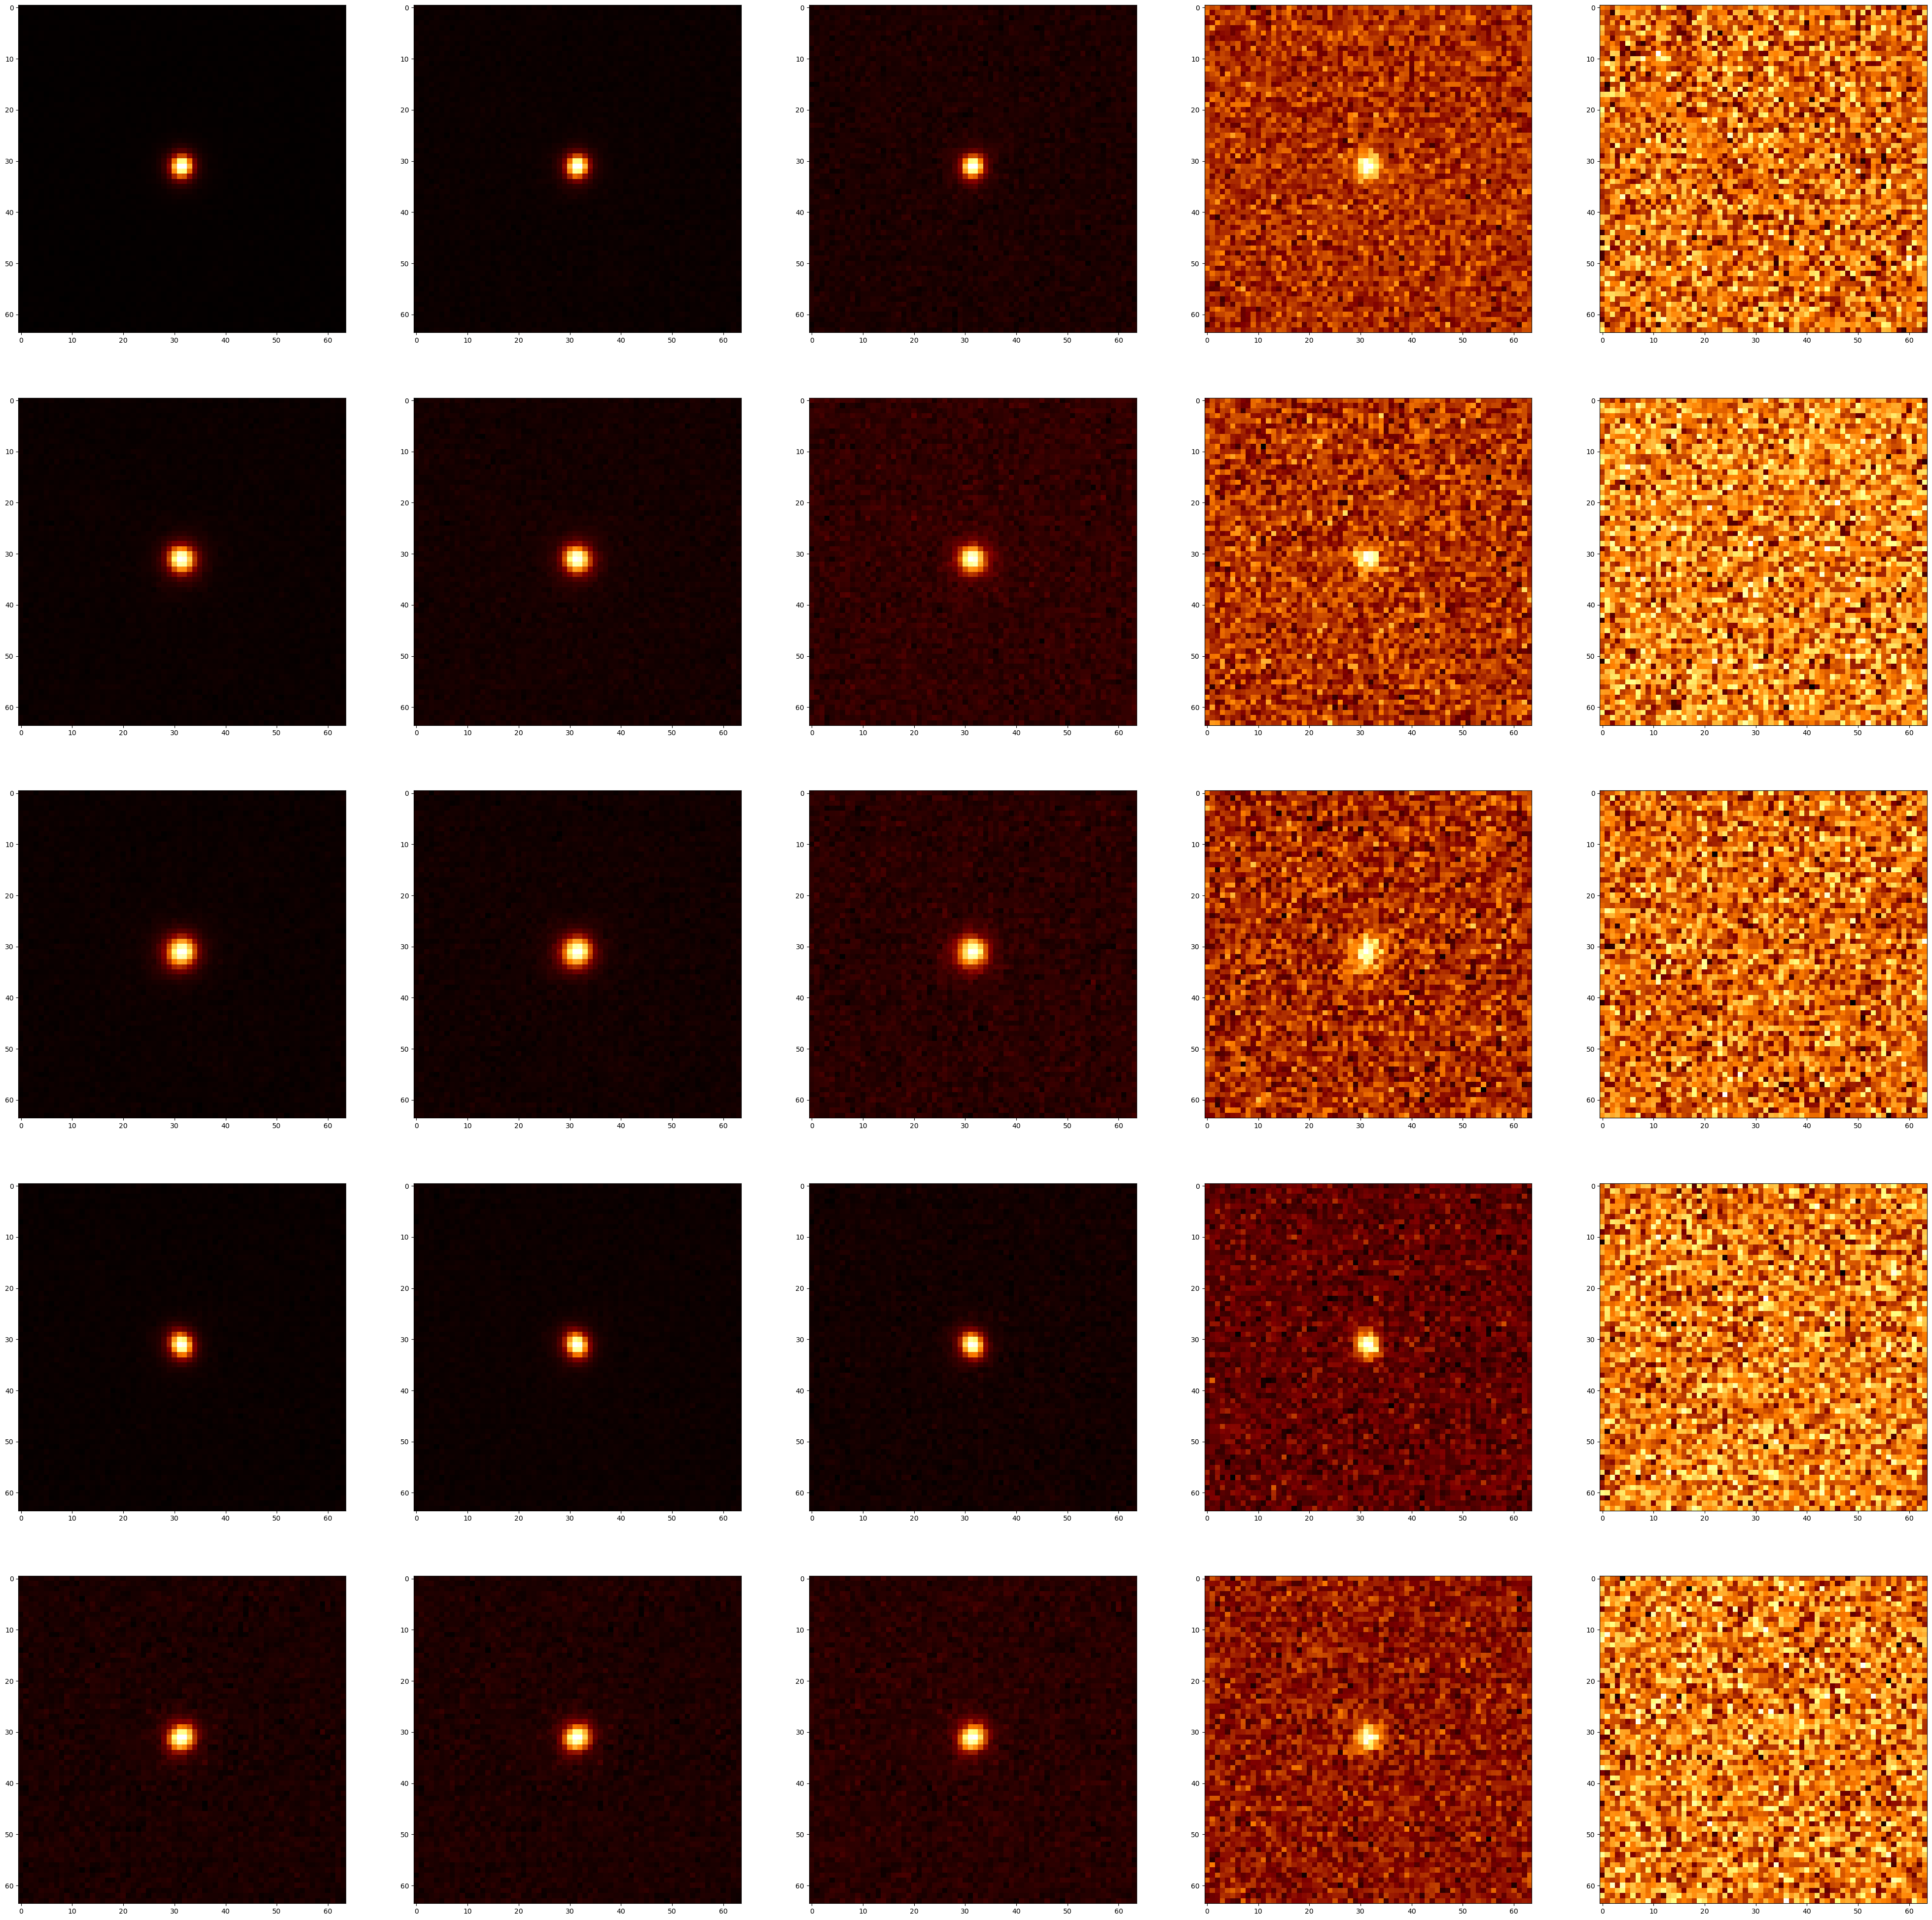

In [6]:
fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (50, 50))

j = 0

for index, i in enumerate([0, 50, 150, 500, 999]):
    noisy_im, noise = forward_noise(np.expand_dims(sample, 0), np.array([i, ]))
    axes[0][j].imshow(noisy_im[0][0], cmap = 'afmhot')
    axes[1][j].imshow(noisy_im[0][1], cmap = 'afmhot')
    axes[2][j].imshow(noisy_im[0][2], cmap = 'afmhot')
    axes[3][j].imshow(noisy_im[0][3], cmap = 'afmhot')
    axes[4][j].imshow(noisy_im[0][4], cmap = 'afmhot')
    j += 1
    

plt.show()

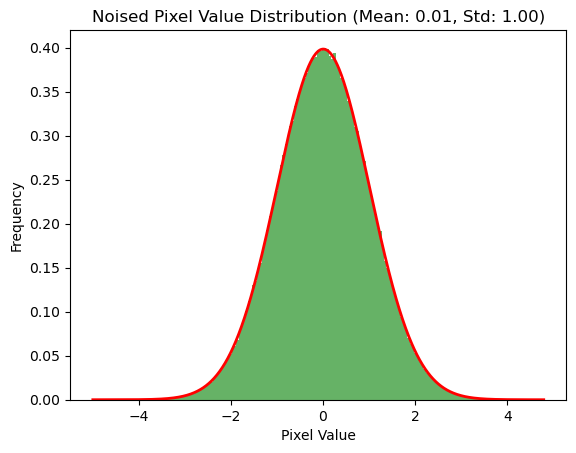

In [7]:
from scipy.stats import norm
from scipy.optimize import curve_fit

sample = train_gen[0][0]

noised_im, noise = forward_noise(sample, np.array([999, ]))
pixel_values = noised_im.ravel()
x_values = np.linspace(np.min(pixel_values), np.max(pixel_values), 1000)
# Calculate the normal distribution values for these x_values

bin_size = 0.05
bins = int((np.max(pixel_values) - np.min(pixel_values)) / bin_size)

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp(- (x - mean)**2 / (2 * standard_deviation ** 2))

histogram, bin_edges = np.histogram(pixel_values, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Fit the Gaussian distribution to the histogram data
popt, _ = curve_fit(gaussian, bin_centers, histogram, p0=[0, 1, 1])
fitted_mean, fitted_std = popt[0], popt[2]

# Plot histogram
plt.hist(pixel_values, bins=bins, density=True, alpha=0.6, color='g')

# normal_distribution = len(pixel_values) * probability_in_bin * norm.pdf(x_values, 0, 1)
plt.plot(x_values, gaussian(x_values, *popt), color='r', linewidth=2)

plt.title(f'Noised Pixel Value Distribution (Mean: {fitted_mean:.2f}, Std: {fitted_std:.2f})')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
# plt.xlim(-5, 5)
plt.show()

In [8]:
# helpers functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# We will use this to convert timestamps to time encodings
class SinusoidalPosEmb(Layer):
    def __init__(self, dim, max_positions=10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training=True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)

        return emb
        
# small helper modules
class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training=True):
        return tf.identity(x)


class Residual(Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(x, training=training) + x

def Upsample(dim):
    return nn.Conv2DTranspose(filters=dim, kernel_size=4, strides=2, padding='SAME')

def Downsample(dim):
    return nn.Conv2D(filters=dim, kernel_size=4, strides=2, padding='SAME')

class LayerNorm(Layer):
    def __init__(self, dim, eps=1e-5, **kwargs):
        super(LayerNorm, self).__init__(**kwargs)
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, dim, 1, 1]))
        self.b = tf.Variable(tf.zeros([1, dim, 1, 1]))

    def call(self, x, training=True):
        var = tf.math.reduce_variance(x, axis=1, keepdims=True)
        mean = tf.reduce_mean(x, axis=1, keepdims=True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x
    
class LayerNormChannelsFirst(Layer):
    def __init__(self, dim, eps=1e-5, **kwargs):
        super(LayerNormChannelsFirst, self).__init__(**kwargs)
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, 1, 1, dim]))
        self.b = tf.Variable(tf.zeros([1, 1, 1, dim]))

    def call(self, x, training=True):
        var = tf.math.reduce_variance(x, axis=-1, keepdims=True)
        mean = tf.reduce_mean(x, axis=-1, keepdims=True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x

class PreNorm(Layer):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def call(self, x, training=True):
        x = self.norm(x)
        return self.fn(x)

class SiLU(Layer):
    def __init__(self):
        super(SiLU, self).__init__()

    def call(self, x, training=True):
        return x * tf.nn.sigmoid(x)

def gelu(x, approximate=False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class GELU(Layer):
    def __init__(self, approximate=False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training=True):
        return gelu(x, self.approximate)

In [9]:
# building block modules
class Block(Layer):
    def __init__(self, dim, groups=8):
        super(Block, self).__init__()
        self.proj = nn.Conv2D(dim, kernel_size=3, strides=1, padding='SAME')
        self.norm = tfa.layers.GroupNormalization(groups, epsilon=1e-05, axis=1)
        self.act = SiLU()


    def call(self, x, gamma_beta=None, training=True):
        x = self.proj(x)
        x = self.norm(x, training=training)

        if exists(gamma_beta):
            gamma, beta = gamma_beta
            x = x * (gamma + 1) + beta

        x = self.act(x)
        return x

class ResnetBlock(Layer):
    def __init__(self, dim, dim_out, time_emb_dim=None, groups=8):
        super(ResnetBlock, self).__init__()

        self.mlp = Sequential([
            SiLU(),
            nn.Dense(units=dim_out * 2)
        ]) if exists(time_emb_dim) else None

        self.block1 = Block(dim_out, groups=groups)
        self.block2 = Block(dim_out, groups=groups)
        self.res_conv = nn.Conv2D(filters=dim_out, kernel_size=1, strides=1) if dim != dim_out else Identity()

    def call(self, x, time_emb=None, training=True):
        gamma_beta = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            gamma_beta = tf.split(time_emb, num_or_size_splits=2, axis=1)

        h = self.block1(x, gamma_beta=gamma_beta, training=training)
        h = self.block2(h, training=training)

        return h + self.res_conv(x)

class LinearAttention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(LinearAttention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.attend = nn.Softmax()
        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False, data_format='channels_last')

        self.to_out = Sequential([
            nn.Conv2D(filters=dim, kernel_size=1, strides=1, data_format='channels_last'),
            LayerNormChannelsFirst(dim)
        ])

    def call(self, x, training=True):
        
        x = tf.transpose(x, [0, 2, 3, 1])
        
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)

        q = tf.nn.softmax(q, axis=-2)
        k = tf.nn.softmax(k, axis=-1)

        q = q * self.scale
        context = einsum('b h d n, b h e n -> b h d e', k, v)

        out = einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b x y (h c)', h=self.heads, x=h, y=w)
        out = self.to_out(out, training=training)

        out = tf.transpose(out, [0, 3, 1, 2])
        return out
    
class Attention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(Attention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False, data_format='channels_last')
        self.to_out = nn.Conv2D(filters=dim, kernel_size=1, strides=1, data_format='channels_last')

    def call(self, x, training=True):
        
        x = tf.transpose(x, [0, 2, 3, 1])
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)
        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        sim_max = tf.stop_gradient(tf.expand_dims(tf.argmax(sim, axis=-1), axis=-1))
        sim_max = tf.cast(sim_max, tf.float32)
        sim = sim - sim_max
        attn = tf.nn.softmax(sim, axis=-1)

        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b x y (h d)', x = h, y = w)
        out = self.to_out(out, training=training)
        
        out = tf.transpose(out, [0, 3, 1, 2])
        return out
    
class Conditioning(Layer):
    def __init__(self, res, num_channels=5):
        super().__init__()
        self.block = Sequential([
            nn.Dense(num_channels * res * res),
            SiLU(),
            nn.Reshape((num_channels, res, res))
        ])

        self.block.compile()

    def call(self, x):
        return self.block(x)

In [10]:
class Unet_conditional(Model):
    def __init__(self,
                 dim=64,
                 init_dim=None,
                 out_dim=None,
                 dim_mults=(1, 2, 4, 8, 16),
                 channels=5,
                 resnet_block_groups=8,
                 learned_variance=False,
                 sinusoidal_cond_mlp=True,
                 in_res=64
                 ):
        super(Unet_conditional, self).__init__()

        # determine dimensions
        self.channels = channels
        self.in_res = in_res

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME')

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        resnet_block_class = partial(ResnetBlock, groups = resnet_block_groups)
        
        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp

        self.time_mlp = Sequential([
                SinusoidalPosEmb(dim),
                nn.Dense(units=time_dim),
                GELU(),
                nn.Dense(units=time_dim)
            ], name="time embeddings")

        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)

        now_res = in_res

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                Conditioning(now_res),
                resnet_block_class(dim_in+1, dim_out, time_emb_dim=time_dim),
                resnet_block_class(dim_out, dim_out, time_emb_dim=time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else Identity()
            ])

            now_res //= 2 if not is_last else 1

        mid_dim = dims[-1]
        self.mid_conditioning = Conditioning(now_res)
        self.mid_block1 = resnet_block_class(mid_dim+1, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = resnet_block_class(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                Conditioning(now_res),
                resnet_block_class((dim_out * 2) + 1, dim_in, time_emb_dim=time_dim),
                resnet_block_class(dim_in, dim_in, time_emb_dim=time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else Identity()
            ])

            now_res *= 2 if not is_last else 1

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_conv = Sequential([
            resnet_block_class(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size=1, strides=1)
        ], name="output")

    def call(self, x, time=None, redshift=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)
        
        h = []

        for conditioning, block1, block2, attn, downsample in self.downs:
            cv = conditioning(redshift)
            x = tf.concat([x, cv], axis=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)
        
        cv = self.mid_conditioning(redshift)
        x = tf.concat([x, cv], axis=1)
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for conditioning, block1, block2, attn, upsample in self.ups:
            cv = conditioning(redshift)
            x = tf.concat([x, cv], axis=1)
            x = tf.concat([x, h.pop()], axis=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis=1)
        x = self.final_conv(x)
        return x

In [11]:
unet = Unet_conditional(
    in_res=64,
    channels=5
)

test_images = np.ones([1, 5, 64, 64])
test_timestamps = generate_timestamp(1)
test_redshift = np.array([[1.0]])
k = unet(test_images, test_timestamps, test_redshift)
opt = keras.optimizers.Adam(learning_rate=learning_rate)

2024-03-24 23:54:02.570389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 19.53GiB (20971520000 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-03-24 23:54:03.146025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-03-24 23:54:03.318018: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-24 23:54:03.578762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [12]:
unet.summary()

Model: "unet_conditional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  10332     
                                                                 
 time embeddings (Sequential  (1, 256)                 82432     
 )                                                               
                                                                 
 conditioning (Conditioning)  multiple                 40960     
                                                                 
 resnet_block (ResnetBlock)  multiple                  100288    
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 107008    
 )                                                               
                                                                 
 residual (Residual)         multiple             

In [13]:
def loss_fn(real, generated):
    loss = tf.math.reduce_mean((real - generated) ** 2)
    return loss

In [14]:
def train_step(batch, condition):
    timestep_values = generate_timestamp(batch.shape[0])

    noised_image, noise = forward_noise(batch, tf.cast(timestep_values, tf.int32))
    with tf.GradientTape() as tape:
        prediction = unet(noised_image, timestep_values, condition)
        
        loss_value = loss_fn(noise, prediction)
    
    gradients = tape.gradient(loss_value, unet.trainable_variables)
    opt.apply_gradients(zip(gradients, unet.trainable_variables))

    return loss_value

In [15]:
epochs = 10
save_frequency = 1

saved_weights_dir = "/data3/Billy/diffusion_saved_weights_extended"
if not os.path.exists(saved_weights_dir):
    os.mkdir(saved_weights_dir)

# Load the latest saved weights, if any
def extract_epoch(filename):
    return int(filename.split('_')[-1].split('.')[0])

# Load the latest saved weights, if any
latest_weights = sorted(glob.glob(f"{saved_weights_dir}/weights_epoch_*"), key = extract_epoch)

if latest_weights:
    
    latest_epoch = int(latest_weights[-1].split('_')[-1].split('.')[0])  # Extract the epoch number from the filename
    unet.load_weights(latest_weights[-1].split('.')[0])
    print(f"Resuming from epoch {latest_epoch + 1}, loaded weights from {latest_weights[-1]}")
    
else:
    
    latest_epoch = -1  # Start from epoch 0
    print("Starting from epoch 0")

Resuming from epoch 30, loaded weights from /data3/Billy/diffusion_saved_weights_extended/weights_epoch_29.data-00000-of-00001


In [15]:
unet.load_weights('/home/billyli/Desktop/weights_epoch_119')

In [16]:
for e in range(latest_epoch + 1, epochs + latest_epoch + 1):
    bar = tf.keras.utils.Progbar(len(train_gen)-1)
    losses = []
    for i, batch in enumerate(iter(train_gen)):
        # run the training loop
        loss = train_step(batch[0], batch[1].reshape(-1, 1))
        losses.append(loss)
        bar.update(i, values=[("loss", loss)])  

    avg = np.mean(losses)
    print(f"Average loss for epoch {e}/{epochs}: {avg}")
    
    if e % save_frequency == 0:
        
        weight_file_path = f"{saved_weights_dir}/weights_epoch_{e}"
        unet.save_weights(weight_file_path)
        print(f"Saved weights to {weight_file_path}")

NameError: name 'latest_epoch' is not defined

In [19]:
def save_gif(img_list, path="", interval=200):
    # Transform images from [-1,1] to [0, 255]
    imgs = []
    for im in img_list:
        im = np.array(im)
        max = np.amax(np.nan_to_num(img_list))
        min = np.amin(np.nan_to_num(img_list))
        im = (im - min) / (max - min) * 255
        im = np.clip(im, 0, 255).astype(np.int32)
        im = Image.fromarray(im)
        imgs.append(im)
    
    imgs = iter(imgs)

    # Extract first image from iterator
    img = next(imgs)

    # Append the other images and save as GIF
    img.save(fp=path, format='GIF', append_images=imgs,
             save_all=True, duration=interval, loop=0)

In [18]:
def ddpm(x_t, pred_noise, t):
    alpha_t = np.take(alpha, t)
    alpha_t_bar = np.take(alpha_bar, t)

    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
    mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

    var = np.take(beta, t)
    z = np.random.normal(size=x_t.shape)

    return mean + (var ** .5) * z

In [ ]:
timesteps = 1000  # Placeholder value

# Set the seed and initialize the initial image

# Function to generate images for a given z value
def generate_images(z_value, x_initial, timesteps):
    x = x_initial
    img_list = [[] for _ in range(5)]  # Lists for g, r, i, z, and y images

    for i in tqdm(range(timesteps - 1), desc=f"Generating images for z={z_value}"):
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, t, np.array([[z_value]]))
        x = ddpm(x, pred_noise, t)
        for j in range(5):
            img_list[j].append(np.squeeze(x, 0)[j])
    
    return [img[-1] for img in img_list]  # Return only the last image of each list

# Generate and plot images for each z value
z_values = np.arange(0.1, 4.1, 0.5)  # z values from 0.01 to 4 in steps of 0.5
final_images = []

for z in z_values:
    x_initial = tf.random.normal((1, 5, 64, 64))
    final_images.append(generate_images(z, x_initial, timesteps))

In [20]:
def save_rgb_gif(img_list, path="", interval=200):
    # Transform images from [-1,1] to [0, 255] and ensure they are in RGB format
    imgs = []
    for im in img_list:
        # Assuming im is a numpy array with shape (height, width, 3) for RGB
        im = np.array(im)
        # Normalize and scale each channel
        max_val = np.amax(im)
        min_val = np.amin(im)
        im = (im - min_val) / (max(max_val - min_val, 1e-5)) * 255  # Avoid division by zero
        im = np.clip(im, 0, 255).astype(np.uint8)  # Clip values to ensure they are within [0, 255]
        imgs.append(Image.fromarray(im, 'RGB'))  # Create an Image object in RGB mode
    
    imgs = iter(imgs)

    # Extract first image from iterator
    img = next(imgs)

    # Append the other images and save as GIF
    img.save(fp=path, format='GIF', append_images=imgs,
             save_all=True, duration=interval, loop=0)

In [27]:
timesteps = 1000  # Placeholder value

# Set the seed and initialize the initial image

# Function to generate images for a given z value
def generate_images_false_color(z_value, x_initial, timesteps):
    x = x_initial
    img_list = []
    
    img_rgb_list = []

    for i in tqdm(range(timesteps - 1), desc=f"Generating images for z={z_value}"):
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, t, np.array([[z_value]]))
        x = ddpm(x, pred_noise, t)
        img_list.append(np.squeeze(x, 0))
        
        # img_list.append(np.squeeze(x_initial, 0))
            
    # return img_list
    
    for image in img_list:
        
        image = np.maximum(image, 0)

        percentile_99 = np.percentile(image, 99)
        image = image / percentile_99 if percentile_99 != 0 else image
        image = np.minimum(image, 1)

        bands = [image[i] for i in range(5)]

        colors = ['purple', 'blue', 'green', 'yellow', 'red']
        colored_bands = []

        for band, color in zip(bands, colors):

            colored_band = np.zeros((64, 64, 3), dtype=np.float32)

            if color == 'purple':
                colored_band[:, :, 2] = band  # Blue channel
            elif color == 'blue':
                colored_band[:, :, 2] = band / 2  # Blue channel
                colored_band[:, :, 1] = band / 2  # Green channel
            elif color == 'green':
                colored_band[:, :, 1] = band  # Green channel
            elif color == 'yellow':
                colored_band[:, :, 1] = band / 2  # Green channel
                colored_band[:, :, 0] = band / 2  # Red channel
            elif color == 'red':
                colored_band[:, :, 0] = band  # Red channel

            colored_bands.append(colored_band)

        combined_image = np.mean(colored_bands, axis=0) 
        combined_image = combined_image/ np.max(combined_image)
        
        img_rgb_list.append(combined_image)    
    
    return img_rgb_list # Return only the last image of each list

# Generate and plot images for each z value
z_values = np.arange(0.01, 4.01, 0.5)  # z values from 0.01 to 4 in steps of 0.5
z_values = np.append(z_values, 4)

final_images = []

for z in z_values:
    x_initial = tf.random.normal((1, 5, 64, 64))
    final_images.append(generate_images_false_color(z, x_initial, timesteps))

Generating images for z=4.0: 100%|██████████| 999/999 [03:06<00:00,  5.35it/s]


In [24]:
def save_rgb_gif_every_10th_frame(img_list, path="", interval=200, final_frame_duration=1000, final_frame_repeat=5):
    imgs = []
    # Include only every 10th frame
    for i, im in enumerate(img_list):
        
        if i % 20 == 0:  # This selects every 10th frame, including the first one (i.e., when i is 0, 10, 20, ...)
            im = np.array(im)
            # max_val = np.amax(im)
            # min_val = np.amin(im)
            im = im * 255 # im = (im - min_val) / (max(max_val - min_val, 1e-5)) * 255
            im = np.clip(im, 0, 255).astype(np.uint8)
            imgs.append(Image.fromarray(im, 'RGB'))
    
    # Append the last image multiple times to extend its visibility, if necessary
    last_img = imgs[-1]
    for _ in range(final_frame_repeat - 1):  # Subtract 1 because the last frame is already in imgs
        imgs.append(last_img)
    
    # The first image in the list
    img = imgs[0]

    # Set durations per frame
    # For all frames except the last repeated ones, use the normal interval
    # For the last repeated frames, use the final_frame_duration
    durations = [interval] * (len(imgs) - final_frame_repeat) + [final_frame_duration] * final_frame_repeat

    img.save(fp=path, format='GIF', append_images=imgs[1:],
             save_all=True, duration=durations, loop=0)
    
    png_path = path.rsplit('.', 1)[0] + '.png'
    last_img.save(png_path, 'PNG')

In [28]:
output_dir = "diffusion_generations"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(len(final_images)):
    save_rgb_gif_every_10th_frame(final_images[i], f"{output_dir}/new_{0.5*i+0.01}.gif", interval = 0.01)

In [24]:
x_initial = tf.random.normal((1, 5, 64, 64))
image_new_gen = generate_images(0.1, x_initial, timesteps)

Generating images for z=0.1: 100%|██████████| 999/999 [03:04<00:00,  5.41it/s]


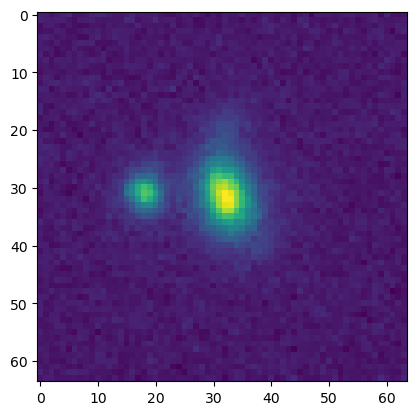

In [25]:
plt.imshow(image_new_gen[0])

saved_image_gen = image_new_gen

In [37]:
final_images[0] = image_new_gen

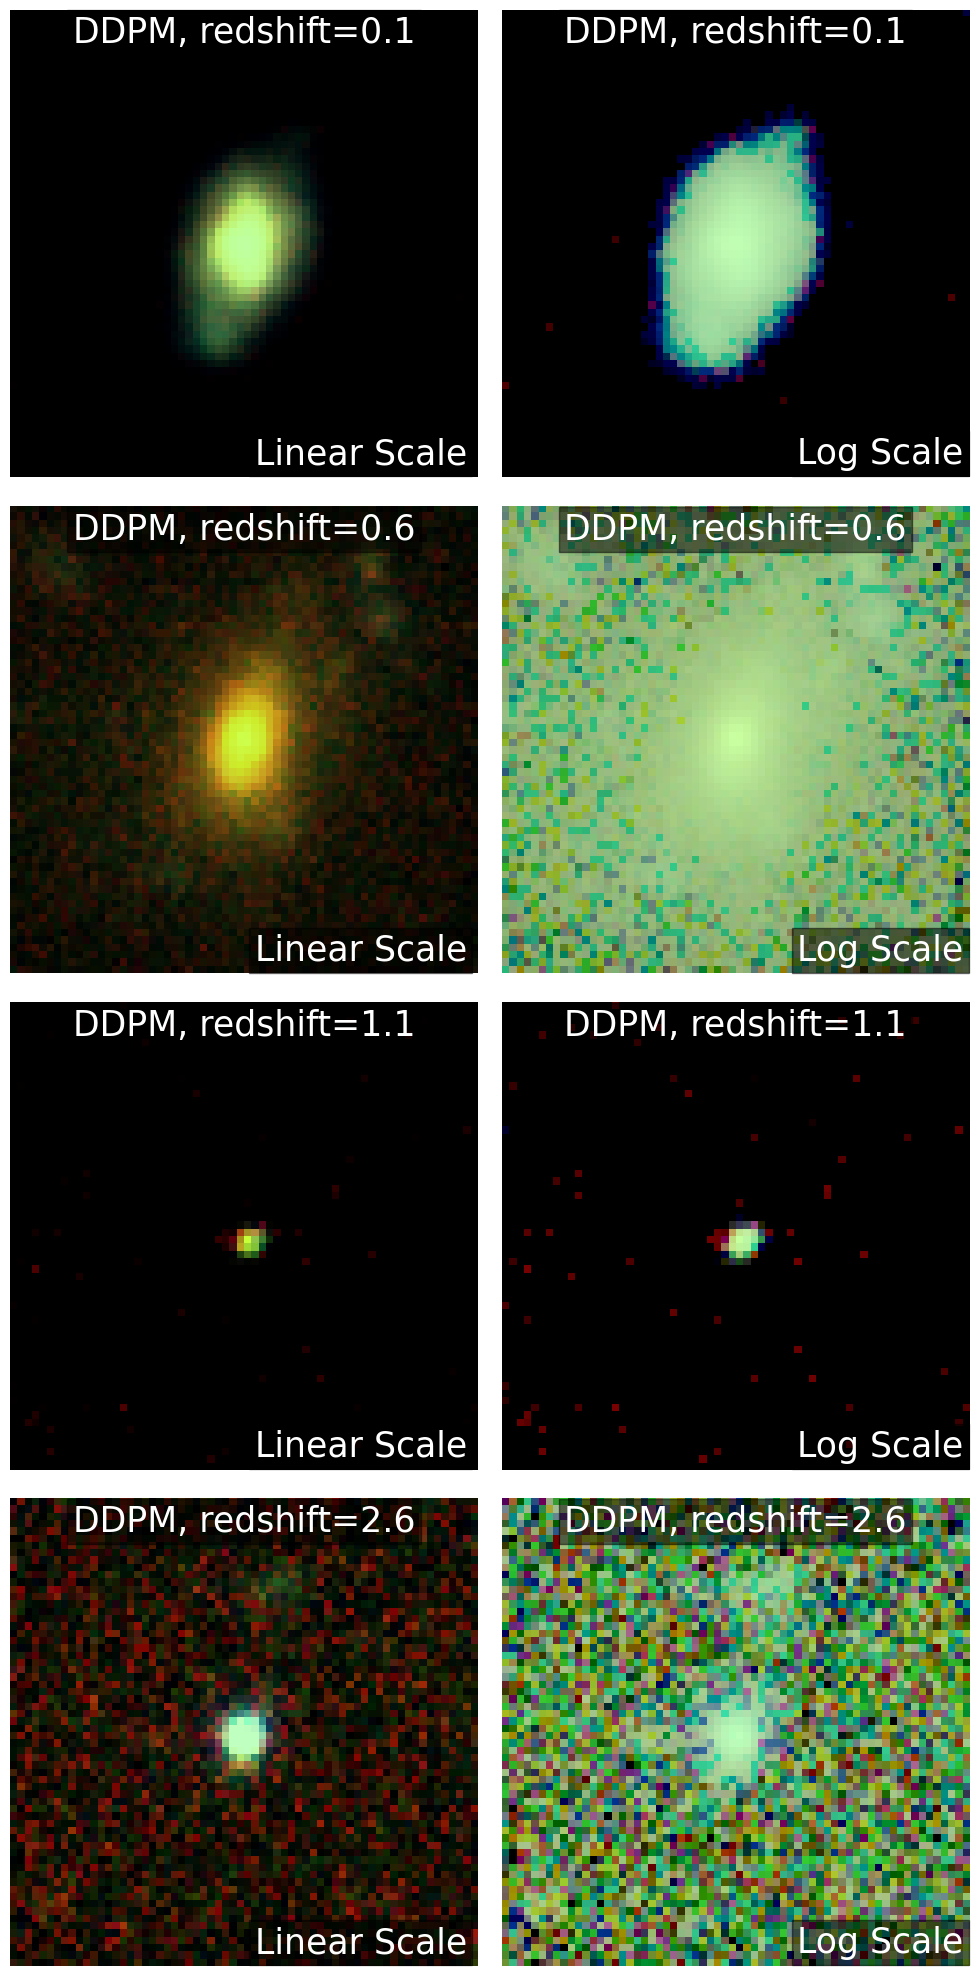

In [38]:
def visualize_bands(image, ax, log_scale = False):
    
    image = np.maximum(image, 0)

    if log_scale:
        min_non_zero = np.min(image[np.nonzero(image)])
        image = np.where(image == 0, min_non_zero, image)
        image = np.log(image)  # Apply natural log
        min_value = np.min(image)
        max_value = np.max(image)
        image = (image - min_value) / (max_value - min_value)
    else:
        percentile_99 = np.percentile(image, 99)
        image = image / percentile_99 if percentile_99 != 0 else image
        image = np.minimum(image, 1)
    
    bands = [image[i] for i in range(5)]
    
    colors = ['purple', 'blue', 'green', 'yellow', 'red']
    colored_bands = []

    for band, color in zip(bands, colors):
        
        colored_band = np.zeros((64, 64, 3), dtype=np.float32)

        if color == 'purple':
            colored_band[:, :, 2] = band  # Blue channel
        elif color == 'blue':
            colored_band[:, :, 2] = band / 2  # Blue channel
            colored_band[:, :, 1] = band / 2  # Green channel
        elif color == 'green':
            colored_band[:, :, 1] = band  # Green channel
        elif color == 'yellow':
            colored_band[:, :, 1] = band / 2  # Green channel
            colored_band[:, :, 0] = band / 2  # Red channel
        elif color == 'red':
            colored_band[:, :, 0] = band  # Red channel

        colored_bands.append(colored_band)

    combined_image = np.mean(colored_bands, axis=0) 
    combined_image = combined_image/ np.max(combined_image)

    ax.imshow(combined_image)
    ax.axis('off')


selected_indices = [0, 1, 2, 5]  # Example: display the 1st, 3rd, and 5th images

# Adjust the number of subplots based on the number of selected images
n_selected_images = len(selected_indices)
fig, axes = plt.subplots(n_selected_images, 2, figsize=(10, 5*n_selected_images))

for i, idx in enumerate(selected_indices):
    image = final_images[idx]
    visualize_bands(image, axes[i, 0])  # Linear scale
    visualize_bands(image, axes[i, 1], log_scale=True)  # Log scale

    # Adding text with a background to each subplot
    axes[i, 0].text(0.5, 0.95, f'DDPM, redshift={z_values[idx]}', ha='center', va='center', 
                    transform=axes[i, 0].transAxes, color='white', fontsize=25,
                    bbox=dict(facecolor='black', alpha=0.5))
    
    axes[i, 0].text(0.75, 0.05, f'Linear Scale', ha='center', va='center', 
                    transform=axes[i, 0].transAxes, color='white', fontsize=25,
                    bbox=dict(facecolor='black', alpha=0.5))
    
    axes[i, 1].text(0.5, 0.95, f'DDPM, redshift={z_values[idx]}', ha='center', va='center', 
                    transform=axes[i, 1].transAxes, color='white', fontsize=25,
                    bbox=dict(facecolor='black', alpha=0.5))
    
    axes[i, 1].text(0.81, 0.05, f'Log Scale', ha='center', va='center', 
                    transform=axes[i, 1].transAxes, color='white', fontsize=25,
                    bbox=dict(facecolor='black', alpha=0.5))

plt.tight_layout()
plt.savefig('ddpm_galaxy_examples_selected_3.png')
plt.show()

In [19]:
def visualize_bands(image, ax, log_scale = False):
    
    image = np.maximum(image, 0)

    if log_scale:
        min_non_zero = np.min(image[np.nonzero(image)])
        image = np.where(image == 0, min_non_zero, image)
        image = np.log(image)  # Apply natural log
        min_value = np.min(image)
        max_value = np.max(image)
        image = (image - min_value) / (max_value - min_value)
    else:
        percentile_99 = np.percentile(image, 99)
        image = image / percentile_99 if percentile_99 != 0 else image
        image = np.minimum(image, 1)
    
    bands = [image[i] for i in range(5)]
    
    colors = ['purple', 'blue', 'green', 'yellow', 'red']
    colored_bands = []

    for band, color in zip(bands, colors):
        
        colored_band = np.zeros((64, 64, 3), dtype=np.float32)

        if color == 'purple':
            colored_band[:, :, 2] = band  # Blue channel
        elif color == 'blue':
            colored_band[:, :, 2] = band / 2  # Blue channel
            colored_band[:, :, 1] = band / 2  # Green channel
        elif color == 'green':
            colored_band[:, :, 1] = band  # Green channel
        elif color == 'yellow':
            colored_band[:, :, 1] = band / 2  # Green channel
            colored_band[:, :, 0] = band / 2  # Red channel
        elif color == 'red':
            colored_band[:, :, 0] = band  # Red channel

        colored_bands.append(colored_band)

    combined_image = np.mean(colored_bands, axis=0) 
    combined_image = combined_image/ np.max(combined_image)

    ax.imshow(combined_image)
    ax.axis('off')

n_images = len(final_images)
fig, axes = plt.subplots(n_images, 2, figsize=(10, 5*n_images))  # Now 2 columns

for i, image in enumerate(final_images):
    visualize_bands(image, axes[i, 0])  # Linear scale
    visualize_bands(image, axes[i, 1], log_scale=True)  # Log scale
    axes[i, 0].set_title(f'Linear - z={z_values[i]}')
    axes[i, 1].set_title(f'Log - z={z_values[i]}')

plt.tight_layout()
plt.savefig('ddpm_galaxy_examples.png')
plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1000x0 with 0 Axes>

In [ ]:
selected_indices = [0, 1, 2, 5]  # Example: display the 1st, 3rd, and 5th images

# Adjust the number of subplots based on the number of selected images
n_selected_images = len(selected_indices)
fig, axes = plt.subplots(n_selected_images, 2, figsize=(10, 5*n_selected_images))

for i, idx in enumerate(selected_indices):
    image = final_images[idx]
    visualize_bands(image, axes[i, 0])  # Linear scale
    visualize_bands(image, axes[i, 1], log_scale=True)  # Log scale

    # Adding text with a background to each subplot
    axes[i, 0].text(0.5, 0.1, f'Linear - z={z_values[idx]}', ha='center', va='center', 
                    transform=axes[i, 0].transAxes, color='white', fontsize=25,
                    bbox=dict(facecolor='black', alpha=0.5))
    axes[i, 1].text(0.5, 0.1, f'Log - z={z_values[idx]}', ha='center', va='center', 
                    transform=axes[i, 1].transAxes, color='white', fontsize=25,
                    bbox=dict(facecolor='black', alpha=0.5))

plt.tight_layout()
plt.savefig('ddpm_galaxy_examples_selected.png')
plt.show()

204
0
1
9
12
4
39
2
73
7
31
9
70
5
311
3


NameError: name 'visualize_bands' is not defined

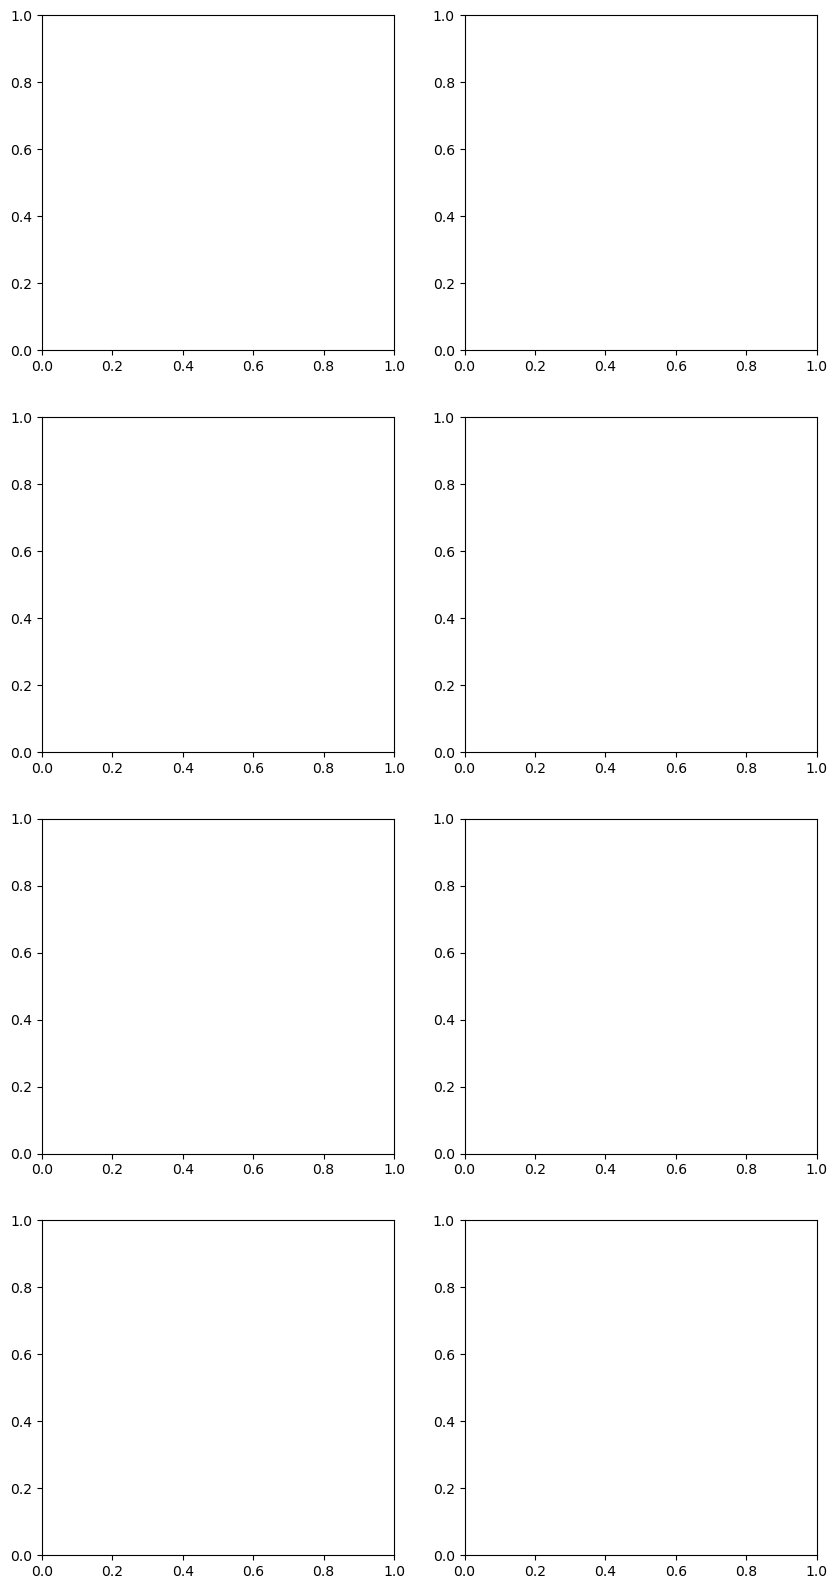

In [7]:
z_values = np.arange(0.1, 4.1, 0.5)  # z values from 0.01 to 4 in steps of 0.5
final_images = []

real_image_list = []

for z_value in z_values:
    for i in range(1000):
        for j in range(10):
            # print(test_gen[i][1][j])
            if test_gen[i][1][j] >= z_value and test_gen[i][1][j] <= z_value * 1.01:
                real_image_list.append(test_gen[i][0][j])
                print(i)
                print(j)
                break  # This will exit the innermost loop
        else:
            continue  # This will only be executed if the inner loop didn't break
        break  # This will exit the second loop if the innermost loop broke
        
selected_indices = [0, 1, 2, 5]  # Example: display the 1st, 3rd, and 5th images

# Adjust the number of subplots based on the number of selected images
n_selected_images = len(selected_indices)
fig, axes = plt.subplots(n_selected_images, 2, figsize=(10, 5*n_selected_images))

for i, idx in enumerate(selected_indices):
    image = real_image_list[idx]
    visualize_bands(image, axes[i, 0])  # Linear scale
    visualize_bands(image, axes[i, 1], log_scale=True)  # Log scale

    # Adding text with a background to each subplot
    axes[i, 0].text(0.5, 0.95, f'Real, redshift={z_values[idx]}', ha='center', va='center', 
                    transform=axes[i, 0].transAxes, color='white', fontsize=25,
                    bbox=dict(facecolor='black', alpha=0.5))
    
    axes[i, 0].text(0.75, 0.05, f'Linear Scale', ha='center', va='center', 
                    transform=axes[i, 0].transAxes, color='white', fontsize=25,
                    bbox=dict(facecolor='black', alpha=0.5))
    
    axes[i, 1].text(0.5, 0.95, f'Real, redshift={z_values[idx]}', ha='center', va='center', 
                    transform=axes[i, 1].transAxes, color='white', fontsize=25,
                    bbox=dict(facecolor='black', alpha=0.5))
    
    axes[i, 1].text(0.81, 0.05, f'Log Scale', ha='center', va='center', 
                    transform=axes[i, 1].transAxes, color='white', fontsize=25,
                    bbox=dict(facecolor='black', alpha=0.5))

plt.tight_layout()
plt.savefig('real_galaxy_examples_selected_2.png')
plt.show()

In [23]:
len(final_images)

0

/tmp/ipykernel_1228015/873678517.py:48: RuntimeWarning: invalid value encountered in log
  axes[i * 2 + 1, j].imshow(np.log(image[j] + 1), cmap='gray')  # Adding 1 to avoid log(0)


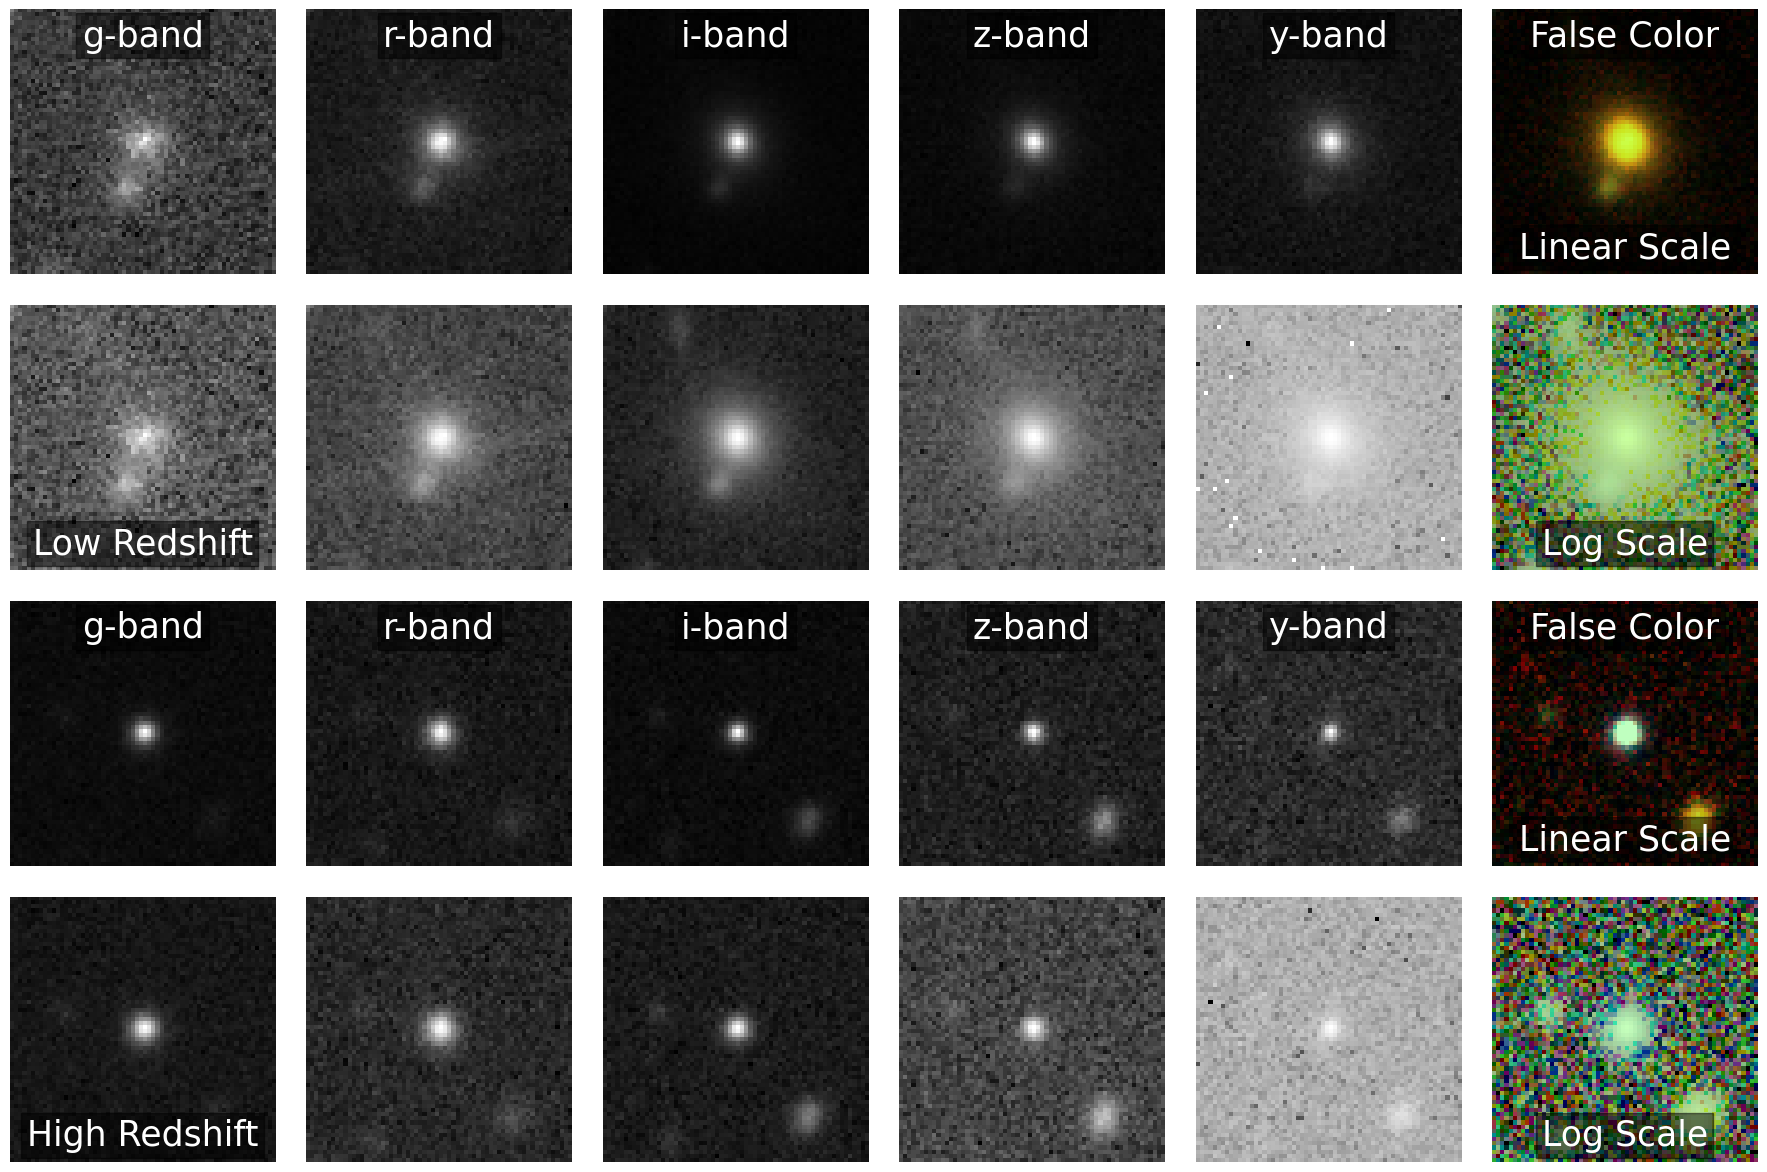

In [24]:
selected_indices = [0, 5]  # Example: display the 1st, 3rd, and 5th images
final_images = [real_image_list[0], real_image_list[5]]

# Adjust the number of subplots based on the number of selected images
n_selected_images = len(selected_indices)

def display_final_images_with_text(final_images, z_values=z_values):
    num_images = len(final_images)
    fig, axes = plt.subplots(num_images * 2, 6, figsize=(18, 6 * num_images))
    
    for i, image in enumerate(final_images):
        for j in range(5):  # Display individual bands - Linear Scale
            axes[i * 2, j].imshow(image[j], cmap='gray')
            axes[i * 2, j].axis('off')
            
            if j == 0:
                axes[i * 2, j].text(0.5, 0.9, f'g-band', ha='center', va='center', 
                                transform=axes[i * 2, j].transAxes, color='white', fontsize=25,
                                bbox=dict(facecolor='black', alpha=0.5))
            elif j == 1:
                axes[i * 2, j].text(0.5, 0.9, f'r-band', ha='center', va='center', 
                                transform=axes[i * 2, j].transAxes, color='white', fontsize=25,
                                bbox=dict(facecolor='black', alpha=0.5))
            elif j == 2:
                axes[i * 2, j].text(0.5, 0.9, f'i-band', ha='center', va='center', 
                                transform=axes[i * 2, j].transAxes, color='white', fontsize=25,
                                bbox=dict(facecolor='black', alpha=0.5))
            elif j == 3:
                axes[i * 2, j].text(0.5, 0.9, f'z-band', ha='center', va='center', 
                                transform=axes[i * 2, j].transAxes, color='white', fontsize=25,
                                bbox=dict(facecolor='black', alpha=0.5))
            elif j == 4:
                axes[i * 2, j].text(0.5, 0.9, f'y-band', ha='center', va='center', 
                                transform=axes[i * 2, j].transAxes, color='white', fontsize=25,
                                bbox=dict(facecolor='black', alpha=0.5))

        visualize_bands(image, axes[i * 2, 5], log_scale=False)  # Combined Image - Linear Scale

        axes[i * 2, 5].text(0.5, 0.9, f'False Color', ha='center', va='center', 
                                transform=axes[i * 2, 5].transAxes, color='white', fontsize=25,
                                bbox=dict(facecolor='black', alpha=0.5))
        axes[i * 2, 5].text(0.5, 0.1, f'Linear Scale', ha='center', va='center', 
                                transform=axes[i * 2, 5].transAxes, color='white', fontsize=25,
                                bbox=dict(facecolor='black', alpha=0.5))
        
        
        for j in range(5):  # Display individual bands - Log Scale
            axes[i * 2 + 1, j].imshow(np.log(image[j] + 1), cmap='gray')  # Adding 1 to avoid log(0)
            axes[i * 2 + 1, j].axis('off')

        visualize_bands(image, axes[i * 2 + 1, 5], log_scale=True)  # Combined Image - Log Scale
        
        axes[i * 2 + 1, 5].text(0.5, 0.1, f'Log Scale', ha='center', va='center', 
                                transform=axes[i * 2 + 1, 5].transAxes, color='white', fontsize=25,
                                bbox=dict(facecolor='black', alpha=0.5))
        
    axes[1, 0].text(0.5, 0.1, f'Low Redshift', ha='center', va='center', 
                            transform=axes[1, 0].transAxes, color='white', fontsize=25,
                            bbox=dict(facecolor='black', alpha=0.5))
    
    axes[3, 0].text(0.5, 0.1, f'High Redshift', ha='center', va='center', 
                            transform=axes[3, 0].transAxes, color='white', fontsize=25,
                            bbox=dict(facecolor='black', alpha=0.5))
        
    plt.tight_layout()
    plt.show()
    
display_final_images_with_text(final_images)

/tmp/ipykernel_1327902/2967762046.py:32: RuntimeWarning: invalid value encountered in log
  axes[i * 2 + 1, j].imshow(np.log(image[j] + 1), cmap='gray')  # Adding 1 to avoid log(0)


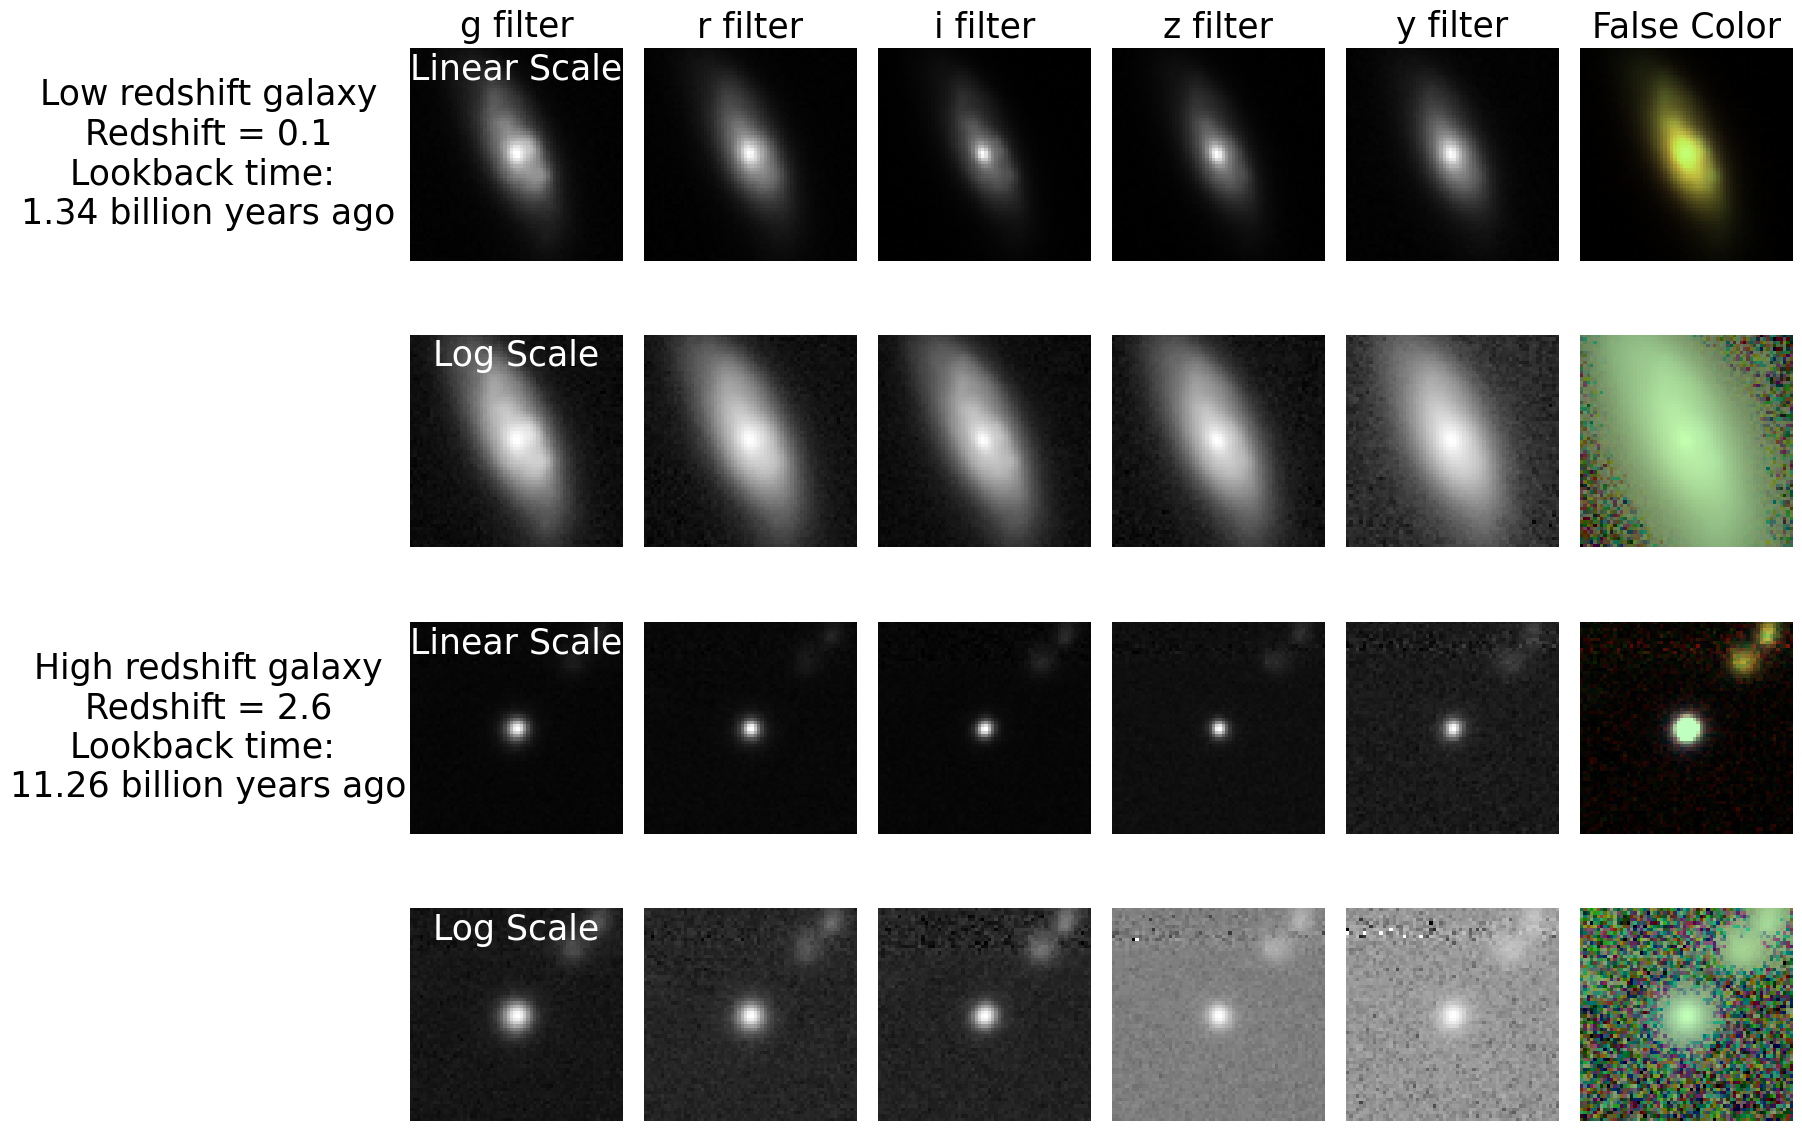

In [47]:
selected_indices = [0, 5]  # Example: display the 1st, 3rd, and 5th images
final_images = [real_image_list[0], real_image_list[5]]

def display_final_images_with_text(final_images, z_values):
    num_images = len(final_images)
    fig, axes = plt.subplots(num_images * 2, 6, figsize=(18, 6 * num_images))

    # Define the labels for the bands and the scale
    band_labels = ['g filter', 'r filter', 'i filter', 'z filter', 'y filter', 'False Color']
    scale_labels = ['Linear Scale', 'Log Scale']
    redshift_labels = ['Low redshift galaxy\nRedshift = ', 'High redshift galaxy\nRedshift = ']

    for i, image in enumerate(final_images):
        for j in range(6):  # Including the combined image
            if j < 5:  # For individual bands
                axes[i * 2, j].imshow(image[j], cmap='gray')
            else:  # For the combined image
                visualize_bands(image, axes[i * 2, j], log_scale=False)

            axes[i * 2, j].axis('off')
            
            if i==0:
                axes[i * 2, j].text(0.5, 1.1, band_labels[j], ha='center', va='center',
                                 transform=axes[i * 2, j].transAxes, color='black', fontsize=25)

            # if j == 5:  # Add the linear scale label for the combined image
                # axes[i * 2, j].text(0.5, 0.9, scale_labels[0], ha='center', va='center',
                                     # transform=axes[i * 2, j].transAxes, color='black', fontsize=25)

            # Log scale for the second row
            if j < 5:  # For individual bands
                axes[i * 2 + 1, j].imshow(np.log(image[j] + 1), cmap='gray')  # Adding 1 to avoid log(0)
            else:  # For the combined image
                visualize_bands(image, axes[i * 2 + 1, j], log_scale=True)

            axes[i * 2 + 1, j].axis('off')

            if j == 0:  # Add the log scale label for the combined image
                axes[i * 2 + 1, j].text(0.5, 0.9, scale_labels[1], ha='center', va='center',
                                         transform=axes[i * 2 + 1, j].transAxes, color='white', fontsize=25)
                axes[i * 2, j].text(0.5, 0.9, scale_labels[0], ha='center', va='center',
                                         transform=axes[i * 2, j].transAxes, color='white', fontsize=25)

        # Add redshift information
        if i == 0:
            axes[i * 2, 0].text(-0.95, 0.5, redshift_labels[i] + str(z_values[i]) + '\nLookback time: \n1.34 billion years ago', ha='center', va='center',
                             transform=axes[i * 2, 0].transAxes, color='black', fontsize=25, rotation=0)
        if i == 1:
            axes[i * 2, 0].text(-0.95, 0.5, redshift_labels[i] + str(z_values[i]) + '\nLookback time: \n11.26 billion years ago', ha='center', va='center',
                             transform=axes[i * 2, 0].transAxes, color='black', fontsize=25, rotation=0)
    
        
    plt.tight_layout()
    
    
    plt.savefig('real_galaxies_showcase.png')
    plt.show()

# Example z_values for the images
z_values = [0.1, 2.6]  # Replace with actual redshift values
display_final_images_with_text(final_images, z_values=z_values)

In [4]:
TEST_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_testing.hdf5'

gen_args_temp = {
    'X_key': 'image',
    'y_key': 'object_id',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'shuffle': False}

test_gen_temp = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args_temp)

37480568979475737


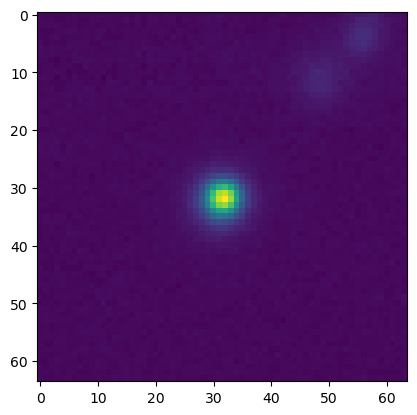

In [22]:
plt.imshow(test_gen_temp[31][0][9][0])
print(test_gen_temp[31][1][9])
#hdu = fits.PrimaryHDU(test_gen_temp[204][0][1][0])
# hdulist = fits.HDUList([hdu])
# hdulist.writeto('temp.fits')

40066646097811224


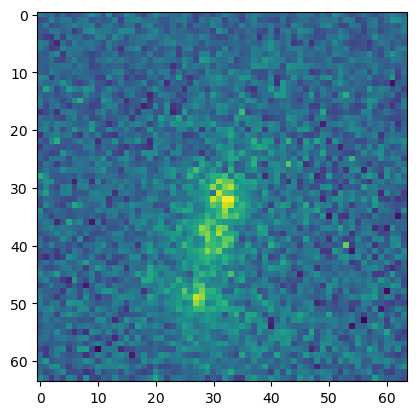

In [8]:
plt.imshow(test_gen_temp[204][0][1][0])
print(test_gen_temp[204][1][1])
#hdu = fits.PrimaryHDU(test_gen_temp[204][0][1][0])
# hdulist = fits.HDUList([hdu])
# hdulist.writeto('temp.fits')

36416246018753893


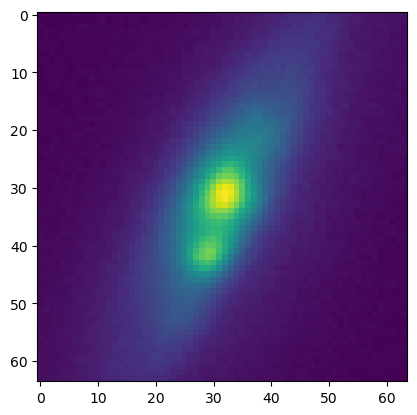

In [5]:
plt.imshow(test_gen_temp[2][0][1][0])
print(test_gen_temp[2][1][1])
hdu = fits.PrimaryHDU(test_gen_temp[2][0][1][0])
hdulist = fits.HDUList([hdu])
hdulist.writeto('temp.fits')

In [ ]:
plt.imshow(low_z_image[1][0])

In [85]:
image = np.maximum(low_z_image[1], 0)

for i in range(1):

    percentile_99 = np.percentile(image, 99)
    image = image / percentile_99 if percentile_99 != 0 else image
    
    image = np.minimum(image, 1)
    
    bands = [image[i] for i in range(5)]
    
    colors = ['purple', 'blue', 'green', 'yellow', 'red']
    colored_bands = []

    for band, color in zip(bands, colors):
        
        colored_band = np.zeros((64, 64, 3), dtype=np.float32)

        if color == 'purple':
            colored_band[:, :, 2] = band  # Blue channel
        elif color == 'blue':
            colored_band[:, :, 2] = band / 2  # Blue channel
            colored_band[:, :, 1] = band / 2  # Green channel
        elif color == 'green':
            colored_band[:, :, 1] = band  # Green channel
        elif color == 'yellow':
            colored_band[:, :, 1] = band / 2  # Green channel
            colored_band[:, :, 0] = band / 2  # Red channel
        elif color == 'red':
            colored_band[:, :, 0] = band  # Red channel

        colored_bands.append(colored_band)

    combined_image = np.mean(colored_bands, axis=0) 
    combined_image = combined_image/ np.max(combined_image)

In [78]:
image = low_z_image[1][0]

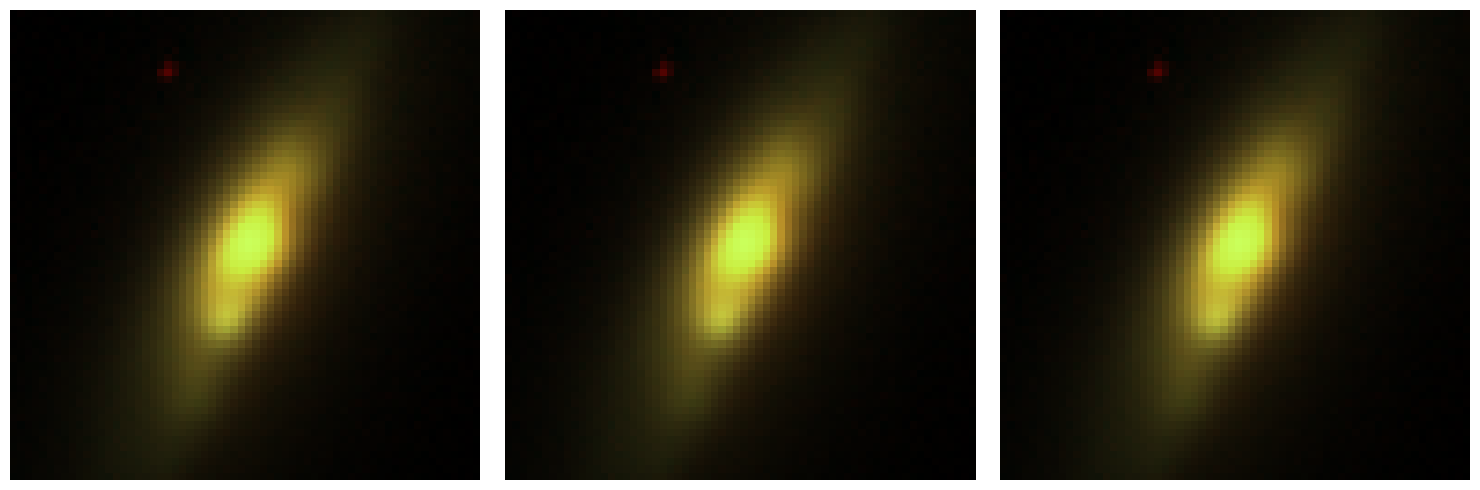

In [118]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image
axs[0].imshow(combined_image)
# axs[0].set_title('Plot 1')
axs[0].axis('off')
# Plot the second image
axs[1].imshow(combined_image)
# axs[1].set_title('Plot 2')
axs[1].axis('off')
# Plot the third image with contours
axs[2].imshow(combined_image, cmap='afmhot')
# axs[2].contour(low_z_image[1][0], colors='black')
# axs[2].set_title('Plot 3 with Contours')
axs[2].axis('off')
# Show the plots
plt.tight_layout()
plt.show()

for k in range(0, 5):
    z = k / 2 + 0.1
    x = tf.random.normal((1, 5, 64, 64))

    img_list_g = []
    img_list_r = []
    img_list_i = []
    img_list_z = []
    img_list_y = []
    img_list_g.append(np.squeeze(x, 0)[0])
    img_list_r.append(np.squeeze(x, 0)[1])
    img_list_i.append(np.squeeze(x, 0)[2])
    img_list_z.append(np.squeeze(x, 0)[3])
    img_list_y.append(np.squeeze(x, 0)[4])
    
    for i in tqdm(range(timesteps - 1)):
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, t, np.array([[z]]))
        x = ddpm(x, pred_noise, t)
        img_list_g.append(np.squeeze(x, 0)[0])
        img_list_r.append(np.squeeze(x, 0)[1])
        img_list_i.append(np.squeeze(x, 0)[2])
        img_list_z.append(np.squeeze(x, 0)[3])
        img_list_y.append(np.squeeze(x, 0)[4])
            

    save_gif(img_list_g + ([img_list_g[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_g.gif", interval = 20)
    save_gif(img_list_r + ([img_list_r[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_r.gif", interval = 20)
    save_gif(img_list_i + ([img_list_i[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_i.gif", interval = 20)
    save_gif(img_list_z + ([img_list_z[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_z.gif", interval = 20)
    save_gif(img_list_y + ([img_list_y[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_y.gif", interval = 20)

In [87]:
z = 0.1
seed = np.random.randint(0, 1000000)
print(seed)
x = tf.random.normal((1, 5, 64, 64), seed=seed)

img_list_g = []
img_list_r = []
img_list_i = []
img_list_z = []
img_list_y = []
img_list_g.append(np.squeeze(x, 0)[0])
img_list_r.append(np.squeeze(x, 0)[1])
img_list_i.append(np.squeeze(x, 0)[2])
img_list_z.append(np.squeeze(x, 0)[3])
img_list_y.append(np.squeeze(x, 0)[4])
    
for i in tqdm(range(timesteps - 1)):
    t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
    pred_noise = unet(x, t, np.array([[z]]))
    x = ddpm(x, pred_noise, t)
    img_list_g.append(np.squeeze(x, 0)[0])
    img_list_r.append(np.squeeze(x, 0)[1])
    img_list_i.append(np.squeeze(x, 0)[2])
    img_list_z.append(np.squeeze(x, 0)[3])
    img_list_y.append(np.squeeze(x, 0)[4])

362514


100%|██████████| 999/999 [03:23<00:00,  4.92it/s]


In [ ]:
z_2 = 3
seed = np.random.randint(0, 1000000)
print(seed)
x_2 = tf.random.normal((1, 5, 64, 64), seed=seed)

img_list_g_2 = []
img_list_r_2 = []
img_list_i_2 = []
img_list_z_2 = []
img_list_y_2 = []
img_list_g_2.append(np.squeeze(x_2, 0)[0])
img_list_r_2.append(np.squeeze(x_2, 0)[1])
img_list_i_2.append(np.squeeze(x_2, 0)[2])
img_list_z_2.append(np.squeeze(x_2, 0)[3])
img_list_y_2.append(np.squeeze(x_2, 0)[4])
    
for i in tqdm(range(timesteps - 1)):
    t_2 = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
    pred_noise_2 = unet(x_2, t_2, np.array([[z_2]]))
    x_2 = ddpm(x_2, pred_noise_2, t_2)
    img_list_g_2.append(np.squeeze(x_2, 0)[0])
    img_list_r_2.append(np.squeeze(x_2, 0)[1])
    img_list_i_2.append(np.squeeze(x_2, 0)[2])
    img_list_z_2.append(np.squeeze(x_2, 0)[3])
    img_list_y_2.append(np.squeeze(x_2, 0)[4])

In [ ]:
y_array = []
for i in range(999):
    rms = np.sqrt(np.mean((img_list_g[i].ravel() - img_list_g_2[i].ravel()) ** 2))
    y_array.insert(0, rms)
y_array_2 = []
sample = train_gen[0][0][0]
sample_2 = train_gen[0][0][1]
for i in range(999):
    noisy_im_1, noise_1 = forward_noise(np.expand_dims(sample, 0), np.array([i, ]))
    noisy_im_2, noise_2 = forward_noise(np.expand_dims(sample_2, 0), np.array([i, ]))
    rms = np.sqrt(np.mean((noisy_im_1.ravel() - noisy_im_2.ravel()) ** 2))
    y_array_2.append(rms)
x_array = range(999)
plt.plot(x_array, y_array, label = 'DDPM')
plt.plot(x_array, y_array_2, label = 'Original')
plt.title('RMS Difference of Pixels')
plt.xlabel('Number of noise steps added/Number of backwards denoise')
plt.ylim(0, 2)

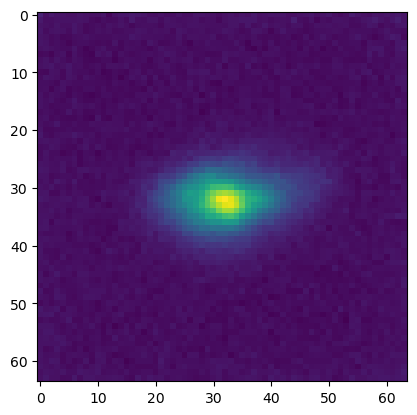

In [96]:
plt.imshow(img_list_y[999])
plt.show()

In [ ]:
plt.imshow(img_list_y_2[999])
plt.show()

Seed: 511024


Generating images for z=2: 100%|██████████| 999/999 [03:07<00:00,  5.32it/s]


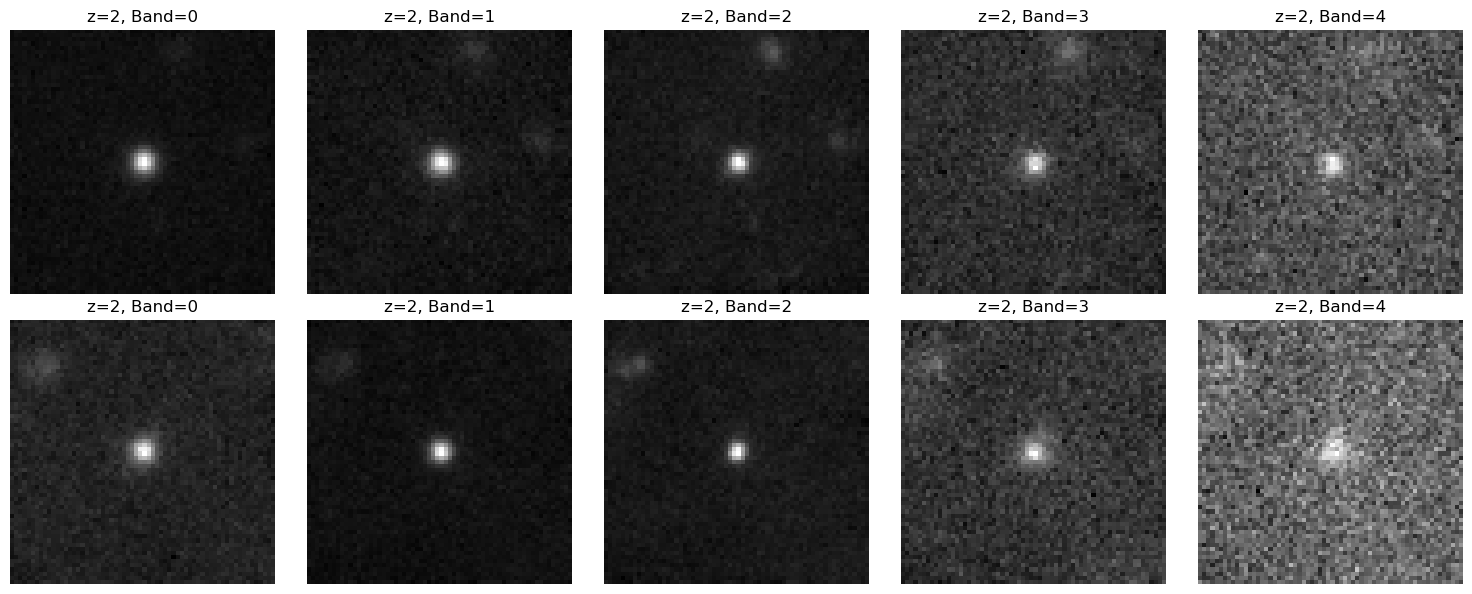

In [18]:
timesteps = 1000  # Placeholder value

# Set the seed and initialize the initial image
seed = np.random.randint(0, 1000000)
print("Seed:", seed)
x_initial = tf.random.normal((1, 5, 64, 64), seed=seed)

# Function to generate images for a given z value
def generate_images(z_value, x_initial, timesteps):
    x = x_initial
    img_list = [[] for _ in range(5)]  # Lists for g, r, i, z, and y images

    for i in tqdm(range(timesteps - 1), desc=f"Generating images for z={z_value}"):
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, t, np.array([[z_value]]))
        x = ddpm(x, pred_noise, t)
        for j in range(5):
            img_list[j].append(np.squeeze(x, 0)[j])
    
    return [img[-1] for img in img_list]  # Return only the last image of each list

# Generate and plot images for each z value
z_values = [2, 2]# np.arange(0.01, 4.01, 0.5)  # z values from 0.01 to 4 in steps of 0.5
final_images = []

for z in z_values:
    final_images.append(generate_images(z, x_initial, timesteps))

# Plotting the final images for each z value
fig, axs = plt.subplots(len(z_values), 5, figsize=(15, 3 * len(z_values)))
for i, z in enumerate(z_values):
    for j in range(5):
        axs[i, j].imshow(final_images[i][j], cmap='gray')
        axs[i, j].set_title(f"z={z}, Band={j}")
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

random_keys = np.random.randint(0, 1000000, 2000)
random_redshift = np.random.uniform(0, 4, 2000)

np.save('/data/HSC_generated/HSC_generated_v1/random_keys.npy', random_keys)
np.save('/data/HSC_generated/HSC_generated_v1/random_redshift.npy', random_redshift)

In [48]:
random_keys = np.load('/data/HSC_generated/HSC_generated_v1/random_keys.npy')
random_redshift = np.load('/data/HSC_generated/HSC_generated_v1/random_redshift.npy')

In [50]:
for i in range(len(random_redshift)):
    if random_redshift[i] <= 0.01:
        print(random_redshift[i])

0.009564294198534551
0.009888857651921601
0.0012468037655128938
0.009827153585153958


In [20]:
total = 2000

hf = h5py.File('/data/HSC_generated/HSC_generated_v1/ddpm_extended/64x64/5x64x64_testing.hdf5', 'a')

fits_dir = "/data/HSC_generated/HSC_generated_v1/ddpm_extended/"
if not os.path.exists(fits_dir):
    os.mkdir(fits_dir)
    
def extract_generated(filename):
    return int(filename.split('_')[-1].split('.')[0])

# Load the latest saved weights, if any
latest_generated = sorted(glob.glob(f"{fits_dir}/y_band_ddpm/ddpm_y_band_*.fits"), key = extract_generated)

if latest_generated:
    
    latest_gen = int(latest_generated[-1].split('_')[-1].split('.')[0]) - 1
    print(f"Resuming to generate image {latest_gen + 1}, overwriting current image {latest_gen + 1} (to prevent fits corruption).")
    
else:
    
    latest_gen = 0  # Start from epoch 0
    print("Generating image 1")

for number_generated in tqdm(range(latest_gen, total)):
    z = random_redshift[number_generated]
    seed = random_keys[number_generated]
    x = tf.random.normal((1, 5, 64, 64), seed=seed)

    for i in range(timesteps - 1):
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, t, np.array([[z]]))
        x = ddpm(x, pred_noise, t)
    
    g_band = np.squeeze(x, 0)[0]
    r_band = np.squeeze(x, 0)[1]
    i_band = np.squeeze(x, 0)[2]
    z_band = np.squeeze(x, 0)[3]
    y_band = np.squeeze(x, 0)[4]
    
    hdul = fits.PrimaryHDU(data = g_band)
    string = f"{fits_dir}/g_band_ddpm/ddpm_g_band_{number_generated + 1}.fits"
    hdul.writeto(string, overwrite = True)
    
    hdul = fits.PrimaryHDU(data = r_band)
    string = f"{fits_dir}/r_band_ddpm/ddpm_r_band_{number_generated + 1}.fits"
    hdul.writeto(string, overwrite = True)
    
    hdul = fits.PrimaryHDU(data = i_band)
    string = f"{fits_dir}/i_band_ddpm/ddpm_i_band_{number_generated + 1}.fits"
    hdul.writeto(string, overwrite = True)
    
    hdul = fits.PrimaryHDU(data = z_band)
    string = f"{fits_dir}/z_band_ddpm/ddpm_z_band_{number_generated + 1}.fits"
    hdul.writeto(string, overwrite = True)
    
    hdul = fits.PrimaryHDU(data = y_band)
    string = f"{fits_dir}/y_band_ddpm/ddpm_y_band_{number_generated + 1}.fits"
    hdul.writeto(string, overwrite = True)
    
    five_band_image = []
    five_band_image.append(g_band)
    five_band_image.append(r_band)
    five_band_image.append(i_band)
    five_band_image.append(z_band)
    five_band_image.append(y_band)
    
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
    
    if number_generated > 0:
        
        hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
        hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
        hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
        hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
    
    else:
        
        hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 64, 64))
        hf.create_dataset('specz_redshift', data = [z], chunks = True, maxshape = (None, ))
    
    # print(f"Saved fits number {number_generated + 1} to {fits_dir}")
    
hf.close()

Resuming to generate image 1951, overwriting current image 1951 (to prevent fits corruption).


100%|██████████| 50/50 [2:34:17<00:00, 185.15s/it]  


In [18]:
random_keys = np.load('/data/HSC_generated/HSC_generated_v1/random_keys.npy')
random_redshift = np.load('/data/HSC_generated/HSC_generated_v1/random_redshift.npy')

In [20]:
# If hdf5 creation failed

total = 2000

hf = h5py.File('/data/HSC_generated/HSC_generated_v1/ddpm_extended/64x64/5x64x64_testing.hdf5', 'a')

fits_dir = "/data/HSC_generated/HSC_generated_v1/ddpm_extended/"

for number_generated in tqdm(range(0, total)):
    z = random_redshift[number_generated]
    
    fits_file = f"{fits_dir}/g_band_ddpm/ddpm_g_band_{number_generated + 1}.fits"
    hdul = fits.open(fits_file)
    g_band = hdul[0].data
    
    fits_file = f"{fits_dir}/r_band_ddpm/ddpm_r_band_{number_generated + 1}.fits"
    hdul = fits.open(fits_file)
    r_band = hdul[0].data
    
    fits_file = f"{fits_dir}/i_band_ddpm/ddpm_i_band_{number_generated + 1}.fits"
    hdul = fits.open(fits_file)
    i_band = hdul[0].data
    
    fits_file = f"{fits_dir}/z_band_ddpm/ddpm_z_band_{number_generated + 1}.fits"
    hdul = fits.open(fits_file)
    z_band = hdul[0].data
    
    fits_file = f"{fits_dir}/y_band_ddpm/ddpm_y_band_{number_generated + 1}.fits"
    hdul = fits.open(fits_file)
    y_band = hdul[0].data
    
    five_band_image = []
    five_band_image.append(g_band)
    five_band_image.append(r_band)
    five_band_image.append(i_band)
    five_band_image.append(z_band)
    five_band_image.append(y_band)
    
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
    
    if number_generated > 0:
        
        hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
        hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
        hf['object_id'].resize((hf['object_id'].shape[0] + 1), axis = 0)
        hf['object_id'][hf['object_id'].shape[0] - 1] = [number_generated + 1]
        hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
        hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
    
    else:
        
        hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 64, 64))
        hf.create_dataset('specz_redshift', data = [z], chunks = True, maxshape = (None, ))
        hf.create_dataset('object_id', data = [number_generated + 1], chunks = True, maxshape = (None, ))
    
    # print(f"Saved fits number {number_generated + 1} to {fits_dir}")
    
hf.close()

100%|██████████| 2000/2000 [00:13<00:00, 148.89it/s]


In [ ]:
# END